# This notebooks will replicate the results obtained by estimating our custom Covid-19 model

In [1]:
import os, sys
sys.path.append(os.path.abspath(os.path.join('../BayesFlow')))

from functools import partial
import datetime

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
from scipy.stats import binom, nbinom

import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LSTM
from tensorflow.keras.models import Sequential

In [2]:
from bayesflow.networks import InvertibleNetwork, InvariantNetwork
from bayesflow.amortizers import SingleModelAmortizer
from bayesflow.trainers import ParameterEstimationTrainer
from bayesflow.diagnostics import *

In [3]:
from abf_functions import *

In [4]:
%load_ext autoreload
%autoreload 2

# Data Loading

In [5]:
confirmed_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
recovered_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
dead_cases_url = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'


confirmed_cases = pd.read_csv(confirmed_cases_url, sep=',')
recovered_cases = pd.read_csv(recovered_cases_url, sep=',')
dead_cases = pd.read_csv(dead_cases_url, sep=',')


date_data_begin = datetime.date(2020,3,1)
date_data_end = datetime.date(2020,5,21)


format_date = lambda date_py: '{}/{}/{}'.format(date_py.month, date_py.day,
                                                 str(date_py.year)[2:4])
date_formatted_begin = format_date(date_data_begin)
date_formatted_end = format_date(date_data_end)

cases_obs =  np.array(
    confirmed_cases.loc[confirmed_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]
recovered_obs =  np.array(
    recovered_cases.loc[recovered_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

dead_obs =  np.array(
    dead_cases.loc[dead_cases["Country/Region"] == "Germany", 
                        date_formatted_begin:date_formatted_end])[0]

data_germany = np.stack([cases_obs, recovered_obs, dead_obs]).T
data_germany = np.diff(data_germany, axis=0)
T_germany = data_germany.shape[0]
N_germany = 83e6
mean_g = np.mean(data_germany, axis=0)
std_g = np.std(data_germany, axis=0)

# Epidemiological Model

In [6]:
alpha_f = (0.7**2)*((1-0.7)/(0.17**2) - (1-0.7))
beta_f = alpha_f*(1/0.7 - 1)


def prior_sir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    t1 = np.random.normal(loc=8, scale=3)
    t2 = np.random.normal(loc=15, scale=1)
    t3 = np.random.normal(loc=22, scale=1)
    t4 = np.random.normal(loc=66, scale=1) 
    delta_t1 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t2 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t3 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    delta_t4 = np.random.lognormal(mean=np.log(3), sigma=0.3)
    lambd0 = np.random.lognormal(mean=np.log(1.2), sigma=0.5)
    lambd1 = np.random.lognormal(mean=np.log(0.6), sigma=0.5)
    lambd2 = np.random.lognormal(mean=np.log(0.3), sigma=0.5)
    lambd3 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    lambd4 = np.random.lognormal(mean=np.log(0.1), sigma=0.5)
    mu = np.random.lognormal(mean=np.log(1/8), sigma=0.2)
    f_i = np.random.beta(a=alpha_f, b=beta_f)
    phi_i = stats.vonmises(kappa=0.01).rvs()
    f_r = np.random.beta(a=alpha_f, b=beta_f)
    phi_r = stats.vonmises(kappa=0.01).rvs()
    f_d = np.random.beta(a=alpha_f, b=beta_f)
    phi_d = stats.vonmises(kappa=0.01).rvs()
    D_i = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_r = np.random.lognormal(mean=np.log(8), sigma=0.2)
    D_d = np.random.lognormal(mean=np.log(8), sigma=0.2)
    E0 = np.random.gamma(shape=2, scale=30)
    scale_I = np.random.gamma(shape=1, scale=5)
    scale_R = np.random.gamma(shape=1, scale=5)
    scale_D = np.random.gamma(shape=1, scale=5)
    return [t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, 
            lambd0, lambd1, lambd2, lambd3, lambd4, mu, 
            f_i, phi_i, f_r, phi_r, f_d, phi_d, 
            D_i, D_r, D_d, E0, scale_I, scale_R, scale_D]


def prior_secir():
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """
    
    alpha = np.random.uniform(low=0.005, high=0.9)
    beta = np.random.lognormal(mean=np.log(0.25), sigma=0.3)
    gamma = np.random.lognormal(mean=np.log(1/6.5), sigma=0.5)
    eta = np.random.lognormal(mean=np.log(1/3.2), sigma=0.3)
    theta = np.random.uniform(low=1/14, high=1/3)
    delta = np.random.uniform(low=0.01, high=0.3)
    d = np.random.uniform(low=1/14, high=1/3)
    return [alpha, beta, gamma, eta, theta, delta, d]


def calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                      t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T):
    """Computes the array of time-varying contact rates/transimission probabilities."""
    
    # Array of initial lambdas
    lambd0_arr = np.array([lambd0] * (t1+sim_lag))
    
    # Compute lambd1 array
    if delta_t1 == 1:
        lambd1_arr = np.array([lambd1] * (t2-t1))
    else:
        lambd1_arr = np.linspace(lambd0, lambd1, delta_t1)
        lambd1_arr = np.append(lambd1_arr, [lambd1] * (t2-t1-delta_t1))
        
    # Compute lambd2 array
    if delta_t2 == 1:
        lambd2_arr = np.array([lambd2] * (t3-t2))
    else:
        lambd2_arr = np.linspace(lambd1, lambd2, delta_t2)
        lambd2_arr = np.append(lambd2_arr, [lambd2] * (t3-t2-delta_t2))
        
    # Compute lambd3 array
    if delta_t3 == 1:
        lambd3_arr = np.array([lambd3] * (t4-t3))
    else:
        lambd3_arr = np.linspace(lambd3, lambd4, delta_t3)
        lambd3_arr = np.append(lambd3_arr, [lambd3] * (t4-t3-delta_t3))
        
    # Compute lambd4 array
    if delta_t4 == 1:
        lambd4_arr = np.array([lambd4] * (T-t4))
    else:
        lambd4_arr = np.linspace(lambd3, lambd4, delta_t4)
        lambd4_arr = np.append(lambd4_arr, [lambd4] * (T-t4-delta_t4))
    
    return np.r_[lambd0_arr, lambd1_arr, lambd2_arr, lambd3_arr, lambd4_arr]

    
def non_stationary_SEICR(params_sir, params_secir, N, T, sim_diff=16, observation_model=True):
    """
    Performs a forward simulation from the stationary SIR model.
    """
    
    # Extract parameters 
    t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, lambd0, lambd1, lambd2, lambd3, lambd4, mu, f_i, phi_i, f_r, phi_r, f_d, phi_d, delay_i, delay_r, delay_d, E0, scale_I, scale_R, scale_D = params_sir
    alpha, beta, gamma, eta, theta, delta, d = params_secir
    
    # Round integer parameters
    t1, t2, t3, t4 = int(round(t1)), int(round(t2)), int(round(t3)), int(round(t4))
    delta_t1, delta_t2, delta_t3, delta_t4 = int(round(delta_t1)), int(round(delta_t2)), int(round(delta_t3)), int(round(delta_t4))
    E0 = max(1, np.round(E0)) 
    delay_i = int(round(delay_i)) 
    delay_r = int(round(delay_r)) 
    delay_d = int(round(delay_d)) 
    
    # Impose constraints
    assert sim_diff > delay_i
    assert sim_diff > delay_r
    assert sim_diff > delay_d
    assert t1 > 0 and t2 > 0 and t3 > 0 and t4 > 0
    assert t1 < t2 < t3 < t4
    assert delta_t1 > 0 and delta_t2 > 0 and delta_t3 > 0 and delta_t4 > 0
    assert t2 - t1 >= delta_t1 and t3 - t2 >= delta_t2 and t4-t3 >= delta_t3 and T-t4 >= delta_t4

    # Calculate lambda arrays
    # Lambda0 is the initial contact rate which will be consecutively
    # reduced via the government measures
    sim_lag = sim_diff - 1
    lambd_arr = calc_lambda_array(sim_lag, lambd0, lambd1, lambd2, lambd3, lambd4, 
                                  t1, t2, t3, t4, delta_t1, delta_t2, delta_t3, delta_t4, T)
 
    # Initial conditions
    S, E, C, I, R, D = [N-E0], [E0], [0], [0], [0], [0]
    
    # Containers
    I_news = []
    R_news = []
    D_news = []
    
    # Reported new cases
    I_data = np.zeros(T)
    R_data = np.zeros(T)
    D_data = np.zeros(T)
    fs_i = np.zeros(T)
    fs_r = np.zeros(T)
    fs_d = np.zeros(T)
 
    # Simulate T-1 tiemsteps
    for t in range(T+sim_lag):
        
        # Calculate new exposed cases
        E_new = lambd_arr[t] * ((C[t] + beta*I[t])/N)*S[t]
    
        # Remove exposed from susceptible
        S_t = S[t] - E_new
        
        # Calculate current exposed by adding new exposed and
        # subtracting the exposed becoming carriers.
        E_t = E[t] + E_new - gamma*E[t]
        
        # Calculate current carriers by adding the new exposed and subtracting
        # those who will develop symptoms and become detected and those who
        # will go through the disease asymptomatically.
        C_t = C[t] + gamma*E[t] - (1-alpha)*eta*C[t] - alpha*theta*C[t]
        
        # Calculate current infected by adding the symptomatic carriers and 
        # subtracting the dead and recovered. The newly infected are just the 
        # carriers who get detected.
        I_t = I[t] + (1-alpha)*eta*C[t] - (1-delta)*mu*I[t] - delta*d*I[t]
        I_new = (1-alpha)*eta*C[t]
        
        # Calculate current recovered by adding the symptomatic and asymptomatic
        # recovered. The newly recovered are only the detected recovered
        R_t = R[t] + alpha*theta*C[t] + (1-delta)*mu*I[t]
        R_new = (1-delta)*mu*I[t]
        
        # Calculate the current dead
        D_t = D[t] + delta*d*I[t]
        D_new = delta*d*I[t]
        
        # Ensure some numerical onstraints
        S_t = np.clip(S_t, 0, N)
        E_t = np.clip(E_t, 0, N)
        C_t = np.clip(C_t, 0, N)
        I_t = np.clip(I_t, 0, N)
        R_t = np.clip(R_t, 0, N)
        D_t = np.clip(D_t, 0, N)
        
        # Keep track of process over time
        S.append(S_t)
        E.append(E_t)
        C.append(C_t)
        I.append(I_t)
        R.append(R_t)
        D.append(D_t)
        I_news.append(I_new)
        R_news.append(R_new)
        D_news.append(D_new)
        
        # From here, start adding new cases with delay D
        # Note, we assume the same delay
        if t >= sim_lag:
            
            # Compute lags and add to data arrays
            fs_i[t-sim_lag] = (1-f_i)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_i)) )
            fs_r[t-sim_lag] = (1-f_r)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_r)) )
            fs_d[t-sim_lag] = (1-f_d)*(1 - np.abs( np.sin( (np.pi/7) * (t-sim_lag) - 0.5*phi_d)) )
            I_data[t-sim_lag] = I_news[t-delay_i]
            R_data[t-sim_lag] = R_news[t-delay_r]
            D_data[t-sim_lag] = D_news[t-delay_d]
            
    # Compute weekly modulation
    I_data = (1-fs_i) * I_data
    R_data = (1-fs_r) * R_data
    D_data = (1-fs_d) * D_data
    
    # Add noise
    I_data = stats.t(df=4, loc=I_data, scale=np.sqrt(I_data)*scale_I).rvs()
    R_data = stats.t(df=4, loc=R_data, scale=np.sqrt(R_data)*scale_R).rvs()
    D_data = stats.t(df=4, loc=D_data, scale=np.sqrt(D_data)*scale_D).rvs()
    
    if observation_model:
        return np.stack((I_data, R_data, D_data)).T
    return np.stack((S, E, I, C, R, D)).T

In [7]:
def data_generator(n_sim, n_obs, N=None, sim_diff=21, N_min=10000, N_max=70000000):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    """
    
    # Variable size N
    if N is None:
        N = np.random.randint(N_min, N_max)
        
    # Generate data
    # x is a np.ndarray of shape (batch_size, n_obs, x_dim)
    x = []
    theta = []
    for i in range(n_sim):
        
        # Reject meaningless simulaitons
        x_i = None
        while x_i is None:
            try:
                theta1 = prior_sir()
                theta2 = prior_secir()
                x_i = non_stationary_SEICR(theta1, theta2, N, n_obs, sim_diff=sim_diff)
                x_i = (x_i - mean_g) / std_g
            except:
                 pass
        # Simulate SECIR
        x.append(x_i)
        theta.append(theta1 + theta2)
    x = np.array(x)
    theta = np.array(theta)

    # Convert to tensor, if specified 
    return theta.astype(np.float32), x.astype(np.float32)

In [8]:
param_names = [r'$t_1$', r'$t_2$', r'$t_3$', r'$t_4$',
               r'$\Delta t_1$', r'$\Delta t_2$', r'$\Delta t_3$', r'$\Delta t_4$',
               r'$\lambda_0$', r'$\lambda_1$', r'$\lambda_2$', r'$\lambda_3$', r'$\lambda_4$', 
               r'$\mu$', r'$f_I$', r'$\phi_I$',  r'$f_R$', r'$\phi_R$',  
               r'$f_D$', r'$\phi_D$',
               r'$L_I$', r'$L_R$', r'$L_D$', r'$E_0$', r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$', 
               r'$\alpha$', r'$\beta$', r'$\gamma$',
               r'$\eta$', r'$\theta$', r'$\delta$', r'$d$']

In [9]:
data_gen = partial(data_generator, N=N_germany, sim_diff=16)

# Network Definition

In [10]:
class MultiConvLayer(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_filters=32, strides=1):
        super(MultiConvLayer, self).__init__()
        
        self.convs = [
            Conv1D(n_filters//2, kernel_size=f, strides=strides, 
                                   padding='causal', activation='relu', kernel_initializer='glorot_uniform')
            for f in range(2, 8)
        ]
        self.dim_red = Conv1D(n_filters, 1, 1, activation='relu', kernel_initializer='glorot_uniform')
        
    def call(self, x):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = tf.concat([conv(x) for conv in self.convs], axis=-1)
        out = self.dim_red(out)
        return out
    
    
class MultiConvNet(tf.keras.Model):
    """Implements an inception-inspired conv layer using different kernel sizes"""
    def __init__(self, n_layers=3, n_filters=64, strides=1):
        super(MultiConvNet, self).__init__()
        
        self.net = Sequential([
            MultiConvLayer(n_filters, strides)
            for _ in range(n_layers)
        ])
        
        self.lstm = LSTM(n_filters)
        
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        out = self.net(x)
        out = self.lstm(out)
        return out
    
    
class SummaryNet(tf.keras.Model):
    def __init__(self, n_summary=192):
        super(SummaryNet, self).__init__()
        self.net_I = MultiConvNet(n_filters=n_summary//3)
        self.net_R = MultiConvNet(n_filters=n_summary//3)
        self.net_D = MultiConvNet(n_filters=n_summary//3)
    
    def call(self, x, **args):
        """x is a timeseries of dimensions B timestamps, n_features"""
        
        x = tf.split(x, 3, axis=-1)
        x_i = self.net_I(x[0])
        x_r = self.net_R(x[1])
        x_d = self.net_D(x[2])
        return tf.concat([x_i, x_r, x_d], axis=-1)

In [11]:
meta_dict={
    'n_coupling_layers': 6,
    's_args': {
        'units': [192, 192, 192],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    't_args': {
        'units': [192, 192, 192],
        'activation': 'elu',
        'initializer': 'glorot_uniform',
    },
    'alpha': 1.9,
    'use_permutation': True,
    'use_act_norm': True,
    'n_params': len(param_names),
}


summary_net = SummaryNet()
inference_net = InvertibleNetwork(meta_dict)
amortizer = SingleModelAmortizer(inference_net, summary_net)

2021-10-21 11:11:07.005961: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-21 11:11:07.006202: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Trainer

In [12]:
starter_learning_rate = 0.0005
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    starter_learning_rate,
    decay_steps=1000,
    decay_rate=0.99,
    staircase=True
)


trainer = ParameterEstimationTrainer(
    network=amortizer, 
    generative_model=data_gen,
    loss=mmd_kl_loss,
    learning_rate=learning_rate,
    checkpoint_path=f'export_ckpt/mmd/covid19',
    max_to_keep=1
)

Networks loaded from export_ckpt/mmd/covid19/ckpt-50


## Online Training

In [ ]:
#%%time
#losses = trainer.train_online(epochs=50, iterations_per_epoch=1000, batch_size=64, n_obs=T_germany)

# Blind MM analysis

In [ ]:
import pickle
from abf_functions import *
from tqdm import tqdm

In [ ]:
with open('data/COVID_model_data/data_model_1.pkl', 'rb') as f:
    x_1 = pickle.load(f)['x']
with open('data/COVID_model_data/data_model_2.pkl', 'rb') as f:
    x_2 = pickle.load(f)['x']
with open('data/COVID_model_data/data_model_3.pkl', 'rb') as f:
    x_3 = pickle.load(f)['x']
with open('data/COVID_model_data/data_model_4.pkl', 'rb') as f:
    x_4 = pickle.load(f)['x']

_, x_star = trainer._forward_inference(1000, T_germany)

s_1 = np.array(trainer.network.summary_net(x_1))
s_2 = np.array(trainer.network.summary_net(x_2))
s_3 = np.array(trainer.network.summary_net(x_3))
s_4 = np.array(trainer.network.summary_net(x_4))

In [ ]:
z_psi = np.array(trainer.network.summary_net(x_star))

In [ ]:
x_1.shape

In [ ]:
s_3.shape

In [ ]:
for i, s in enumerate([s_1, s_2, s_3, s_4], 1):
    print(f"data_model_{i}: MMD={float(maximum_mean_discrepancy(s, z_psi, unbiased=True)):.3f}")

In [ ]:
K = 100
MMD = np.empty(K)
for k in range(K):
    _, x = trainer._forward_inference(1, T_germany)
    s  = np.array(trainer.network.summary_net(x))
    MMD[k] = float(maximum_mean_discrepancy(s, z_psi, unbiased=True))

In [ ]:
sns.kdeplot(MMD)
plt.xlim(0)
plt.title("Distribution of 100 MMDs with B=1 data from the trainer's generative model")
plt.axvline(x=MMD_germany_standardized, color="red", linestyle="dashed")
plt.xlabel(r"$\widehat{MMD}^2_u$")

In [ ]:
data_germany_tensor = data_germany[np.newaxis, ...]
data_germany_tensor.shape

In [ ]:
# standardized
data_germany_standardized = (data_germany_tensor - mean_g) / std_g
s_germany_standardized = np.array(trainer.network.summary_net(data_germany_standardized))
MMD_germany_standardized = float(maximum_mean_discrepancy(s_germany_standardized, z_psi, unbiased=True))
print("standardized: MMD =", MMD_germany_standardized)
s_germany_standardized.shape

In [ ]:
# non_standardized
s_germany = np.array(trainer.network.summary_net(data_germany_tensor))
print("non-standardized: MMD =", float(maximum_mean_discrepancy(s_germany, z_psi, unbiased=True)))
s_germany.shape

In [ ]:
mmd2_null = mmd_permutation(s_germany_standardized, z_psi)

In [ ]:
sns.kdeplot(mmd2_null)
plt.xlim(0)
plt.title("Permutation Test Germany Data standardized")
plt.axvline(x=MMD_germany_standardized, color="red", linestyle="dashed")
plt.xlabel(r"$\widehat{MMD}^2_u$")

# PCA

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
_, x = trainer._forward_inference(1000, T_germany)
s = np.array(trainer.network.summary_net(x))

K = 192

pca = PCA(K)
pca.fit(s)

cumsum_explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

In [ ]:
plt.plot(range(1, K+1), cumsum_explained_variance_ratio)
plt.xlabel("Number of PCs")
plt.ylabel("Explained variance all PCs")
plt.ylim(0)
plt.axhline(y=1.0, linestyle="dashed", color="grey")
plt.grid()

In [ ]:
cumsum_explained_variance_ratio[74]

In [ ]:
# Generate data from trainer's generative model
_, x = trainer._forward_inference(1000, T_germany)
s = np.array(trainer.network.summary_net(x))

# Fit PCA to data from trainer
pca = PCA(2)
pca.fit(s)


# Generate more data from trainer's generative model
_, x_star = trainer._forward_inference(1000, T_germany)
s_star = trainer.network.summary_net(x_star)

# Project all candidate data onto the Principal Components
s_star_proj = pca.transform(s_star)
s_1_proj = pca.transform(s_1)
s_2_proj = pca.transform(s_2)
s_3_proj = pca.transform(s_3)
s_4_proj = pca.transform(s_4)

In [ ]:
S = [s_star_proj, s_1_proj, s_2_proj, s_3_proj, s_4_proj]
TASK_NAMES = ['x_star', 'x_1', 'x_2', 'x_3', 'x_4']

DF = (pd.DataFrame(s, 
                     columns=[r'$Proj_{%i}$'%i for i in range(1, 3)]) for s in S)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Model', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Model", palette=['red', 'orange', 'green', 'blue', 'brown'], height=3)

g.map_upper(plt.scatter, alpha=0.1)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.50)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=14)

### Separate PCAs

In [ ]:
# Generate data from trainer's generative model
_, x_star = trainer._forward_inference(1000, T_germany)
s_star = trainer.network.summary_net(x_star)

# Fit and project all data on separate PCAs based on them
s_star_proj = PCA(2).fit_transform(s_star)
s_1_proj = PCA(2).fit_transform(s_1)
s_2_proj = PCA(2).fit_transform(s_2)
s_3_proj = PCA(2).fit_transform(s_3)
s_4_proj = PCA(2).fit_transform(s_4)

In [ ]:
S = [s_star_proj, s_1_proj, s_2_proj, s_3_proj, s_4_proj]
TASK_NAMES = ['x_star', 'x_1', 'x_2', 'x_3', 'x_4']

DF = (pd.DataFrame(s, 
                     columns=[r'$Proj_{%i}$'%i for i in range(1, 3)]) for s in S)

df = pd.concat(DF,
              keys=TASK_NAMES,
              names=['Model', None]
              ).reset_index(level=0)

g = sns.PairGrid(df, hue="Model", palette=['red', 'orange', 'green', 'blue', 'brown'], height=3)

g.map_upper(plt.scatter, alpha=0.1)
g.map_diag(sns.kdeplot)
g.map_lower(sns.kdeplot, alpha=0.50)

g.add_legend()
plt.setp(g._legend.get_title(), fontsize=16)
plt.setp(g._legend.get_texts(), fontsize=14)

# Bootstrapping

In [45]:
from tqdm.notebook import tqdm
import pickle

In [14]:
with open('data/COVID_model_data/data_model_1.pkl', 'rb') as f:
    x_1 = pickle.load(f)['x']
with open('data/COVID_model_data/data_model_2.pkl', 'rb') as f:
    x_2 = pickle.load(f)['x']
with open('data/COVID_model_data/data_model_3.pkl', 'rb') as f:
    x_3 = pickle.load(f)['x']
with open('data/COVID_model_data/data_model_4.pkl', 'rb') as f:
    x_4 = pickle.load(f)['x']

_, x_star = trainer._forward_inference(1000, T_germany)
s_star = np.array(trainer.network.summary_net(x_star))

s_1 = np.array(trainer.network.summary_net(x_1))
s_2 = np.array(trainer.network.summary_net(x_2))
s_3 = np.array(trainer.network.summary_net(x_3))
s_4 = np.array(trainer.network.summary_net(x_4))

In [15]:
MMD_1 = float(maximum_mean_discrepancy(s_1, s_star, unbiased=True))
MMD_2 = float(maximum_mean_discrepancy(s_2, s_star, unbiased=True))
MMD_3 = float(maximum_mean_discrepancy(s_3, s_star, unbiased=True))
MMD_4 = float(maximum_mean_discrepancy(s_4, s_star, unbiased=True))

In [16]:
def MMD_bootstrap(x_star, x_test, N_BOOTSTRAP_ITERATIONS=10):
    n_star = x_star.shape[0]
    n_test = x_test.shape[0]
    
    MMD_bootstrap = np.empty(N_BOOTSTRAP_ITERATIONS)

    for i in tqdm(range(N_BOOTSTRAP_ITERATIONS)):
        idx_star = np.random.randint(0, n_star, size=n_star)
        idx_test = np.random.randint(0, n_test, size=n_test)
        
        x_star_bootstrap = x_star[idx_star]
        x_test_bootstrap = x_test[idx_test]
        
        s_star_bootstrap = np.array(trainer.network.summary_net(x_star_bootstrap))
        s_test_bootstrap = np.array(trainer.network.summary_net(x_test_bootstrap))
        
        MMD_bootstrap[i] = float(maximum_mean_discrepancy(s_star_bootstrap, s_test_bootstrap, unbiased=True))
        
    return MMD_bootstrap

In [17]:
#MMD_1_bootstrap = MMD_bootstrap(x_star, x_1, N_BOOTSTRAP_ITERATIONS=100)
#MMD_2_bootstrap = MMD_bootstrap(x_star, x_2, N_BOOTSTRAP_ITERATIONS=100)
#MMD_3_bootstrap = MMD_bootstrap(x_star, x_3, N_BOOTSTRAP_ITERATIONS=100)
#MMD_4_bootstrap = MMD_bootstrap(x_star, x_4, N_BOOTSTRAP_ITERATIONS=100)

#np.save("data/MMD_bootstrapping/MMD_1_bootstrap.npy", MMD_1_bootstrap)
#np.save("data/MMD_bootstrapping/MMD_2_bootstrap.npy", MMD_2_bootstrap)
#np.save("data/MMD_bootstrapping/MMD_3_bootstrap.npy", MMD_3_bootstrap)
#np.save("data/MMD_bootstrapping/MMD_4_bootstrap.npy", MMD_4_bootstrap)

In [18]:
MMD_1_bootstrap = np.load("data/MMD_bootstrapping/MMD_1_bootstrap.npy")
MMD_2_bootstrap = np.load("data/MMD_bootstrapping/MMD_2_bootstrap.npy")
MMD_3_bootstrap = np.load("data/MMD_bootstrapping/MMD_3_bootstrap.npy")
MMD_4_bootstrap = np.load("data/MMD_bootstrapping/MMD_4_bootstrap.npy")

In [22]:
def calculate_CI(x, ci_area=0.95):
    q_lower = round((1.0 - ci_area) / 2, 5)
    q_upper = round(1.0 - q_lower, 5)
    return np.quantile(x, q_lower), np.quantile(x, q_upper)

In [42]:
MMDs_bootstrap = [MMD_1_bootstrap, MMD_2_bootstrap, MMD_3_bootstrap, MMD_4_bootstrap]

for i, MMD_b in enumerate(MMDs_bootstrap, 1):
    lower_bound, upper_bound = calculate_CI(MMD_b, ci_area=0.95)
    median = np.median(MMD_b)
    print(f"M{i}: {median:.3f} [{lower_bound:.3f}, {upper_bound:.3f}]")

M1: 0.054 [0.044, 0.070]
M2: 2.163 [2.031, 2.299]
M3: 1.514 [1.425, 1.620]
M4: 1.753 [1.693, 1.829]


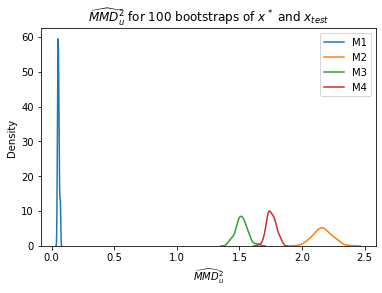

In [19]:
MMDs = [MMD_1, MMD_2, MMD_3, MMD_4]
MMD_bootstraps = [MMD_1_bootstrap, MMD_2_bootstrap, MMD_3_bootstrap, MMD_4_bootstrap]
colors = ["red", "firebrick", "orange", "blue"]

fig, ax = plt.subplots()

for i in range(4):
    sns.kdeplot(MMD_bootstraps[i], ax=ax, label=f"M{i+1}")
    ax.legend()
    ax.set_title(r"$\widehat{MMD}^2_u$ for 100 bootstraps of $x^*$ and $x_{test}$")
    ax.set_xlabel(r"$\widehat{MMD}^2_u$")

In [26]:
def MMD_H0_single_instance(trainer, n_simulations, n_obs, n_simulations_reference=1000, plot=False):
    _, x_star = trainer._forward_inference(n_simulations_reference, n_obs)
    _, x_star_prime = trainer._forward_inference(n_simulations, n_obs)
    s_star = trainer.network.summary_net(x_star)
    s_star_prime = trainer.network.summary_net(x_star_prime)
    
    MMD_H0 = np.empty(n_simulations)
    
    for k in tqdm(range(n_simulations)):
        MMD_H0[k] = float(maximum_mean_discrepancy(s_star, s_star_prime[np.newaxis, k, ...], unbiased=True))
    
    if plot:
        sns.kdeplot(MMD_H0)
    
    return MMD_H0

  0%|          | 0/1000 [00:00<?, ?it/s]

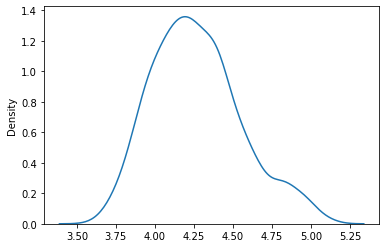

In [27]:
MMD_H0 = MMD_H0_single_instance(trainer, n_simulations=1000, n_obs=T_germany, plot=True)

In [28]:
np.save("data/MMD_power/MMD_H0.npy", MMD_H0)

In [46]:
def MMD_power_analysis(x_star, x_test, MMD_H0, alpha=.05):
    n_test = x_test.shape[0]
    n_star = x_star.shape[0]

    s_test = trainer.network.summary_net(x_test)
    s_star = trainer.network.summary_net(x_star)

    MMDs_test = np.empty(n_test)

    for i in tqdm(range(n_test)):
        MMDs_test[i] = float(maximum_mean_discrepancy(s_star, s_test[np.newaxis, i, ...], unbiased=True))

    MMD_critical = np.quantile(MMD_H0, 1-alpha)    
    power = (MMDs_test > MMD_critical).mean()       
        
    return power, MMDs_test

In [47]:
_, x_star = trainer._forward_inference(1000, T_germany)

In [50]:
#power_1, MMDs_single_1 = MMD_power_analysis(x_star, x_1, MMD_H0, alpha=.05)
#power_2, MMDs_single_2 = MMD_power_analysis(x_star, x_2, MMD_H0, alpha=.05)
#power_3, MMDs_single_3 = MMD_power_analysis(x_star, x_3, MMD_H0, alpha=.05)
#power_4, MMDs_single_4 = MMD_power_analysis(x_star, x_4, MMD_H0, alpha=.05)

#np.save("data/MMD_power/MMDs_single_1.npy", MMDs_single_1)
#np.save("data/MMD_power/MMDs_single_2.npy", MMDs_single_2)
#np.save("data/MMD_power/MMDs_single_3.npy", MMDs_single_3)
#np.save("data/MMD_power/MMDs_single_4.npy", MMDs_single_4)

#np.save("data/MMD_power/power_1.npy", power_1)
#np.save("data/MMD_power/power_2.npy", power_2)
#np.save("data/MMD_power/power_3.npy", power_3)
#np.save("data/MMD_power/power_4.npy", power_4)

In [51]:
MMDs_single_1 = np.load("data/MMD_power/MMDs_single_1.npy")
MMDs_single_2 = np.load("data/MMD_power/MMDs_single_2.npy")
MMDs_single_3 = np.load("data/MMD_power/MMDs_single_3.npy")
MMDs_single_4 = np.load("data/MMD_power/MMDs_single_4.npy")

power_1 = np.load("data/MMD_power/power_1.npy")
power_2 = np.load("data/MMD_power/power_2.npy")
power_3 = np.load("data/MMD_power/power_3.npy")
power_4 = np.load("data/MMD_power/power_4.npy")

for i, power in enumerate([power_1, power_2, power_3, power_4], 1):
    print(f"M{i}: {power:.3f}")

M1: 0.041
M2: 0.358
M3: 0.638
M4: 0.338


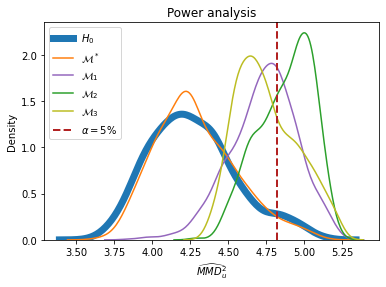

In [75]:
alpha = .05

model_names = [r"$\mathcal{M}^*$", r"$\mathcal{M}_1$", r"$\mathcal{M}_2$", r"$\mathcal{M}_3$"]
colors = ["tab:orange", "tab:purple", "tab:green", "tab:olive"]
MMDs_singles = [MMDs_single_1, MMDs_single_2, MMDs_single_3, MMDs_single_4]

MMD_critical = np.quantile(MMD_H0, 1-alpha)  

fig, ax = plt.subplots()
sns.kdeplot(MMD_H0, linewidth=7, label=r"$H_0$")
for i in range(4):
    sns.kdeplot(MMDs_singles[i], ax=ax, label=model_names[i], color=colors[i])
    ax.set_title(r"Power analysis")
    ax.set_xlabel(r"$\widehat{MMD}^2_u$")
ax.axvline(x=MMD_critical, color="firebrick", linewidth=2, linestyle="dashed", label=r"$\alpha=5\%$")
ax.legend()